2024-09-29 11:33:59.585008: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-29 11:33:59.585843: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-29 11:33:59.590036: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-29 11:33:59.604605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 11:33:59.630932: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 65s 33ms/step - loss: 216.3341 - val_loss: 166.6324
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 63s 34ms/step - loss: 164.8199 - val_loss: 159.6164
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 53s 28ms/step - loss: 158.6608 - val_loss: 156.5962
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 54s 29ms/step - loss: 156.8781 - val_loss: 156.0220
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - loss: 155.4913 - val_loss: 154.5929
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - loss: 154.0816 - val_loss: 153.8713
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 48s 26ms/step - loss: 153.9755 - val_loss: 153.4900
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 51s 27ms/step - loss: 153.3182 - val_loss: 153.0324
Epoch 9/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 57s 30ms/step - loss: 152.3923 - val_loss: 152.8312
Epoch 10/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 55s 29ms/step - loss: 151.6438 - val_loss: 152.0498
Epoch 11/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 52s 28ms/step - 

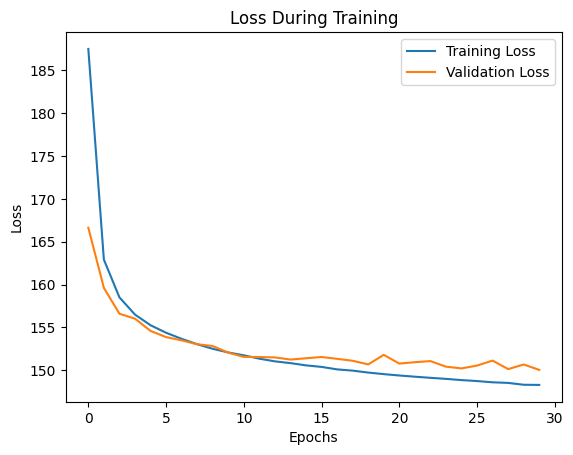

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


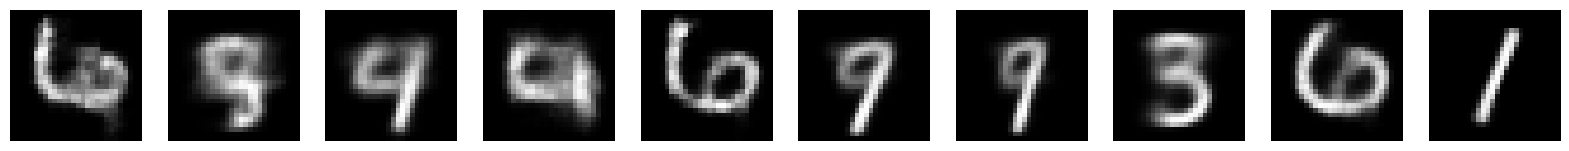

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import numpy as np
import matplotlib.pyplot as plt

# Define the encoder
def build_encoder(latent_dim):
    encoder_input = layers.Input(shape=(28, 28, 1))  # Assuming grayscale images, such as MNIST
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_input)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    
    return models.Model(encoder_input, [z_mean, z_log_var], name="encoder")

# Define the decoder
def build_decoder(latent_dim):
    decoder_input = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation='relu')(decoder_input)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    decoder_output = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    
    return models.Model(decoder_input, decoder_output, name="decoder")

# Sampling layer to draw latent vector 'z' from the distribution
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Custom loss function combining reconstruction loss and KL divergence
def kl_reconstruction_loss(inputs, outputs, z_mean, z_log_var):
    # Reconstruction loss: Binary cross-entropy between original and reconstructed input
    reconstruction_loss = tf.keras.losses.binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
    reconstruction_loss *= 28 * 28  # Assuming image size is 28x28
    
    # KL divergence: Forces latent space to follow a standard normal distribution
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = -0.5 * K.sum(kl_loss, axis=-1)
    
    # Combine both losses
    total_loss = K.mean(reconstruction_loss + kl_loss)
    return total_loss

# Define VAE model class
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = sampling([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        return reconstructed

# Build the encoder and decoder
latent_dim = 2  # Latent space dimensionality (adjustable)
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
vae = VAE(encoder, decoder)

# Compile the VAE using the custom loss function
vae.compile(optimizer='adam', loss=lambda inputs, outputs: kl_reconstruction_loss(inputs, outputs, encoder(inputs)[0], encoder(inputs)[1]))

# Load and preprocess the MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Training the VAE model
history = vae.fit(x=x_train, y=x_train, epochs=30, batch_size=32, validation_data=(x_test, x_test))

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Function to plot generated images
def plot_generated_images(decoder, n=10):
    # Generate random latent vectors
    z_sample = np.random.normal(size=(n, latent_dim))
    # Decode the latent vectors into images
    generated_images = decoder.predict(z_sample)
    
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Generate and plot new images
plot_generated_images(decoder)
